# Glassdoor Search Result Analysis
## `Job title: Data Scientist`
## `Location: Ontario`

# The Dataset:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)

df = pd.read_csv('scrapped jobs - 06-21-2021 18h33m31s.csv')

df

,Company,Job Title,Location,Employer Estimated Salary,Easy Apply,Special Label,Job Age,Overall Rating,Compensation & Benefit,Culture & Value,Career Opportunitie,Work/Life Balanc,Job Type,Job Function,Industry,Size,Founded,Type,Sector,Revenue,Recommend to a friend,Approve of CEO,Total Ratings,Job Description,Scraping Start Time: 06-21-2021 18h33m31s,"Starting Link: https://www.glassdoor.ca/Job/ontario-data-scientist-jobs-SRCH_IL.0,7_IS4080_KO8,22.htm"
0,AIR MILES,Data Scientist Lead,Midtown Toronto,NaN,False,Actively Hiring,3d,3.2,3.1,3.0,2.8,3.3,Full-time,Data Scientist,Advertising & Marketing,501 to 1000 Employees,1992.0,Company - Private,Business Service,$1 to $2 billion (USD),44%,44%,5 Ratings,It's fun to work in a company where people tru...,NaN,NaN
1,Pink Triangle Press,Research & Analytical Director - Data Scientist,Midtown Toronto,CA$84k - CA$106k (Glassdoor Est.),True,Hiring Surge,4d,3.5,3.4,3.7,2.3,3.9,Full-time,Data Scientist,Publishing,51 to 200 Employees,NaN,Company - Private,Media,$1 to $5 million (USD),55%,100%,1 Ratings,Pink Triangle Press (PTP) is looking for a Res...,NaN,NaN
2,Leonardo Canada - Electronics (TTI - Tactical ...,Radar E/W Scientists,Ottawa,NaN,True,NaN,6d,NaN,NaN,NaN,NaN,NaN,Full-time,Research Scientist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"RadarE/W Scientists, Ottawa Canada\r\nRemote w...",NaN,NaN
3,Sun Life Financial,Data Analyst,Waterloo,CA$56k - CA$95k (Glassdoor Est.),False,Top Company,3d,4.0,3.8,4.1,3.8,3.9,Full-time,Data Analyst,Insurance Operator,10000+ Employees,1865.0,Company - Public,Insurance,$10+ billion (USD),84%,96%,370 Ratings,"You are as unique as your background, experien...",NaN,NaN
4,Russell Hendrix Foodservice Equipment,Data Analyst,Midtown Toronto,NaN,True,HOT,16d,3.0,2.9,2.9,2.8,2.9,Full-time,Data Analyst,NaN,501 to 1000 Employees,NaN,Company - Public,NaN,Unknown / Non-Applicable,51%,80%,5 Ratings,"With over 70 years of experience, Russell Hend...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,CyberCoders,Sr. Machine Learning Engineer - Facial Recogni...,Midtown Toronto,NaN,True,New,24h,4.1,3.7,4.0,4.1,3.8,Full-time,Machine Learning Engineer,Staffing & Outsourcing,201 to 500 Employees,1999.0,Subsidiary or Business Segment,Business Service,$100 to $500 million (USD),72%,87%,42 Ratings,Sr. Machine Learning Engineer - Facial Recogni...,NaN,NaN
896,Lixar I.T,Senior Data Engineer,Midtown Toronto,CA$120k - CA$140k (Glassdoor Est.),True,NaN,22d,NaN,NaN,NaN,NaN,NaN,Full-time,Data Engineer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lixar fuelled by BDO is looking for a Senior D...,NaN,NaN
897,Spin Master Ltd,Sr. Data Engineer,Midtown Toronto,CA$95k - CA$120k (Glassdoor Est.),False,NaN,6d,3.1,3.1,3.1,2.9,2.6,Full-time,Data Engineer,Consumer Products Manufacturing,1001 to 5000 Employees,1994.0,Company - Public,Manufacturing,$2 to $5 billion (USD),51%,64%,142 Ratings,Are you a kid at heart looking to build a care...,NaN,NaN
898,Gore Mutual Insurance Company,Lead Data Engineer,Cambridge,NaN,True,NaN,19d,3.0,3.3,3.6,2.9,3.5,Full-time,Data Engineer,Insurance Operator,201 to 500 Employees,1839.0,Company - Private,Insurance,$100 to $500 million (USD),62%,68%,9 Ratings,The Data Engineering practice at Gore Mutual I...,NaN,NaN


# Data Cleaning:

In [2]:
# Drop last two columns
df.drop(columns=['Scraping Start Time: 06-21-2021 18h33m31s', 'Starting Link: https://www.glassdoor.ca/Job/ontario-data-scientist-jobs-SRCH_IL.0,7_IS4080_KO8,22.htm'], inplace=True)

# Drop duplicates()
df.drop_duplicates(inplace=True)

# Ratings distribution:

Text(0, 0.5, 'Number of Postings')

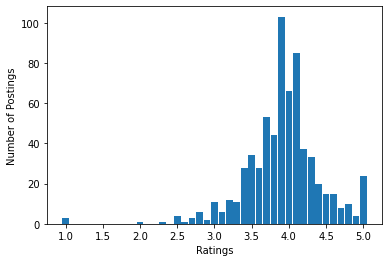

In [3]:
ratings_group = df.groupby('Overall Rating').count()['Company']
ratings = ratings_group.index
company_count = ratings_group
plt.bar(ratings, company_count, width=.09)
plt.xlabel('Ratings')
plt.ylabel('Number of Postings')

# What are the effects of Easy Apply?

In [4]:
# Add 'Job Age in Hours' column

def convert_to_hour(time):
    if time[-1] == 'd':
        return 24*float(time[:-1])
    return float(time[:-1])

# .apply is not the most efficient but we don't have a lot of data
df['Job Age in Hours'] = df['Job Age'].apply(convert_to_hour)


In [5]:
print(df.groupby('Easy Apply').count()['Company'])
df.groupby('Easy Apply').mean()

Easy Apply
False    452
True     267
Name: Company, dtype: int64


,Overall Rating,Compensation & Benefit,Culture & Value,Career Opportunitie,Work/Life Balanc,Founded,Job Age in Hours
Easy Apply,,,,,,,
False,3.937241,3.699307,3.879215,3.695381,3.707852,1955.800518,323.575221
True,3.878541,3.627632,3.860965,3.638596,3.854825,1991.653409,289.438202


## Summary:
### • ~37% of all job postings uses the Easy Apply feature
### • Newer companies use the feature more
### • When Easy Apply is enabled:
### `10% decreased time to fill the position on average`
### `2.5% lower ratings on average`

# What are the effects of Company Age?

In [6]:
# Only looking at unique companies
# Remove rows with duplicate company
company_df = df.drop_duplicates(['Company'], keep='first').drop(columns=['Job Title', 'Job Type','Job Description', 'Employer Estimated Salary', 'Special Label', 'Job Age', 'Easy Apply', 'Job Age in Hours'])

Text(0.5, 1.0, 'Company Age vs Overall Rating')

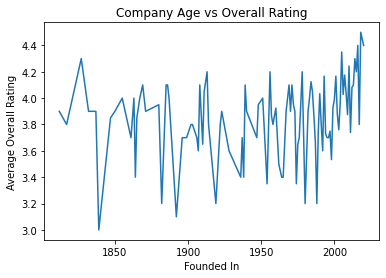

In [7]:
company_df = company_df[~company_df['Founded'].isna()]

founded_group = company_df.groupby('Founded').mean()
founded = founded_group.index

plt.plot(founded, founded_group['Overall Rating'])
plt.xlabel('Founded In')
plt.ylabel('Average Overall Rating')
plt.title('Company Age vs Overall Rating')


Text(0.5, 1.0, 'Company Age vs Career Opportunity')

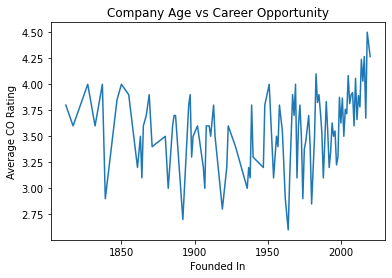

In [8]:
plt.plot(founded, founded_group['Career Opportunitie'])
plt.xlabel('Founded In')
plt.ylabel('Average CO Rating')
plt.title('Company Age vs Career Opportunity')

## Summary:
### • Companies founded after year ~2000 have drastically higher overall ratings and career opportunities ratings

# What are the effects of location?

Text(0.5, 1.0, 'Location vs Career Opportunity')

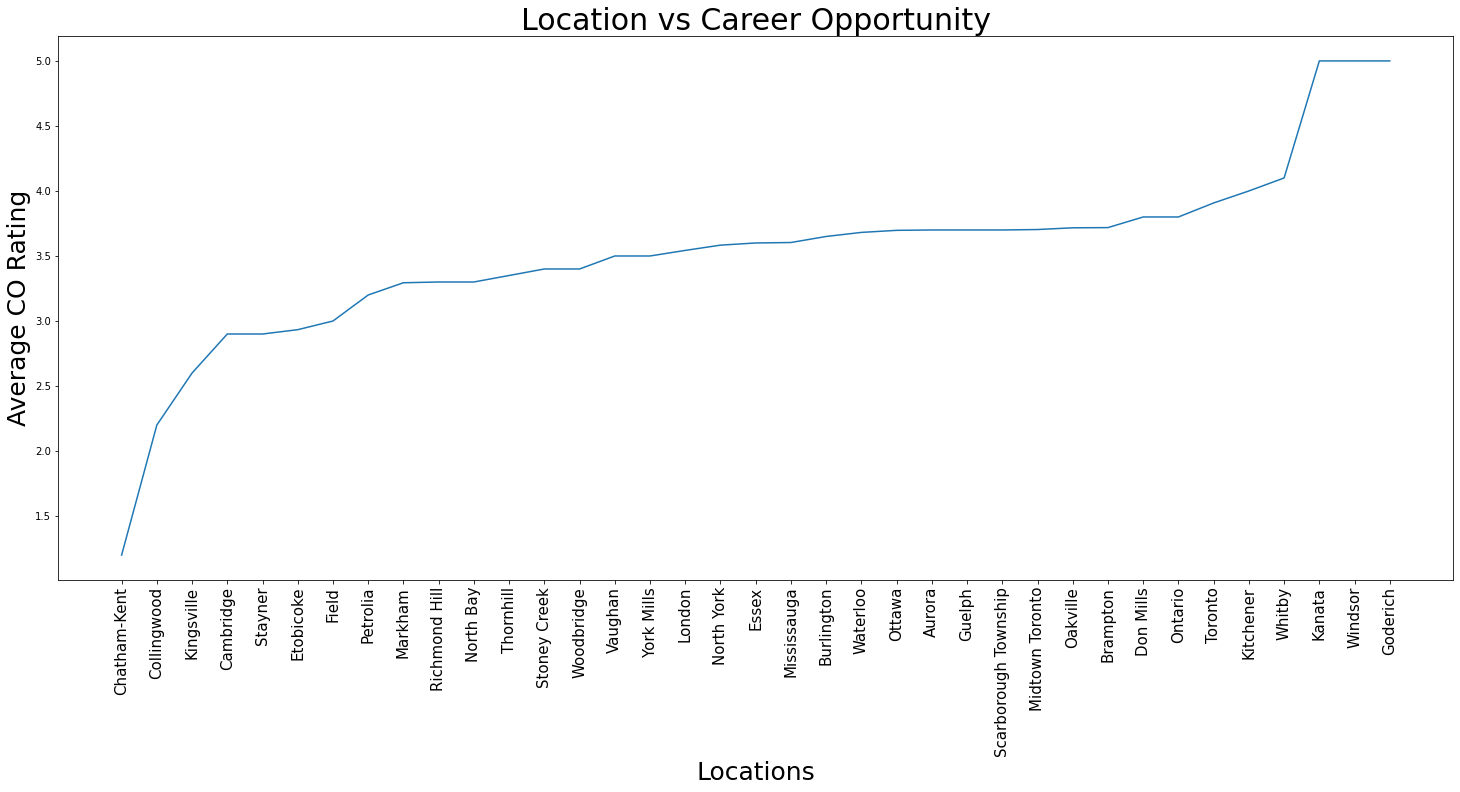

In [9]:
loc_group = df.groupby('Location').mean().sort_values('Career Opportunitie')
# Drop rows where 'Career Opportunities is NaN'
loc_group = loc_group[~loc_group['Career Opportunitie'].isna()]
locations = loc_group.index

plt.figure(figsize=(25,10))

plt.plot(locations, loc_group['Career Opportunitie'])
plt.xticks(locations, rotation='vertical', size=15)
plt.xlabel('Locations', size=25)
plt.ylabel('Average CO Rating',size=25)
plt.title('Location vs Career Opportunity', size=30)



## Create Salary dataframe:

In [10]:
def mean_salary(salary_range):
    if len(salary_range) == 2:
        return 1000 * (float(salary_range[0]) + float(salary_range[1]))/2
    return 1000 * float(salary_range[0])
    
# Remove rows with NaN Salary
salary_df = df[~df['Employer Estimated Salary'].isna()]
salary_df['Estimated Salary'] = salary_df['Employer Estimated Salary'].str.replace('$','').str.replace('CA','').str.replace('(Glassdoor Est.)','').str.replace('k','').str[:-3].str.split(' - ')
salary_df['Estimated Salary'] = salary_df['Estimated Salary'].apply(mean_salary)

# salary_df.sort_values('Estimated Salary', inplace=True)
# salary_df

<ipython-input-10-ba9ee52a21a2>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  salary_df['Estimated Salary'] = salary_df['Employer Estimated Salary'].str.replace('$','').str.replace('CA','').str.replace('(Glassdoor Est.)','').str.replace('k','').str[:-3].str.split(' - ')
<ipython-input-10-ba9ee52a21a2>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  salary_df['Estimated Salary'] = salary_df['Employer Estimated Salary'].str.replace('$','').str.replace('CA','').str.replace('(Glassdoor Est.)','').str.replace('k','').str[:-3].str.split(' - ')
<ipython-input-10-ba9ee52a21a2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

Text(0.5, 1.0, 'Location vs Salary')

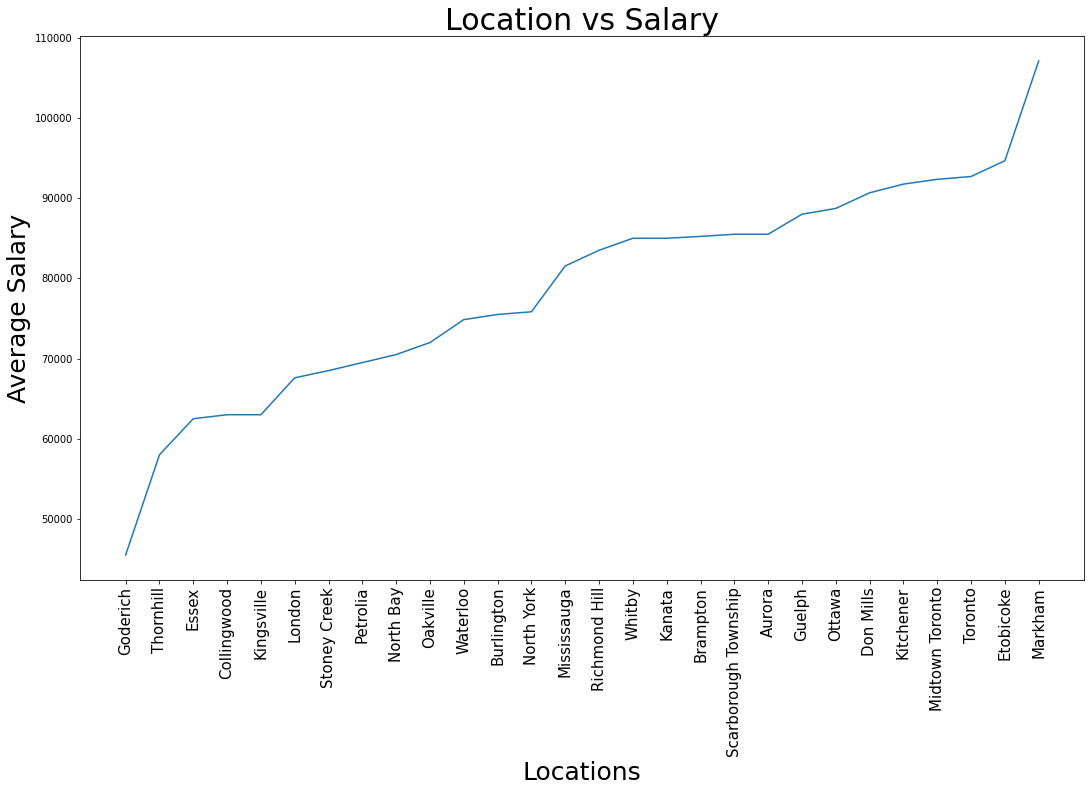

In [11]:
loc_group = salary_df.groupby('Location').mean().sort_values('Estimated Salary')
locations = loc_group.index

plt.figure(figsize=(18,10))

plt.plot(locations, loc_group['Estimated Salary'])
plt.xticks(locations, rotation='vertical', size=15)
plt.xlabel('Locations', size=25)
plt.ylabel('Average Salary',size=25)
plt.title('Location vs Salary', size=30)

<ipython-input-22-7728e2dcf53c>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(locations, rotation='vertical', size=15)


Text(0.5, 1.0, 'Salary vs Career Opportunity (by Location)')

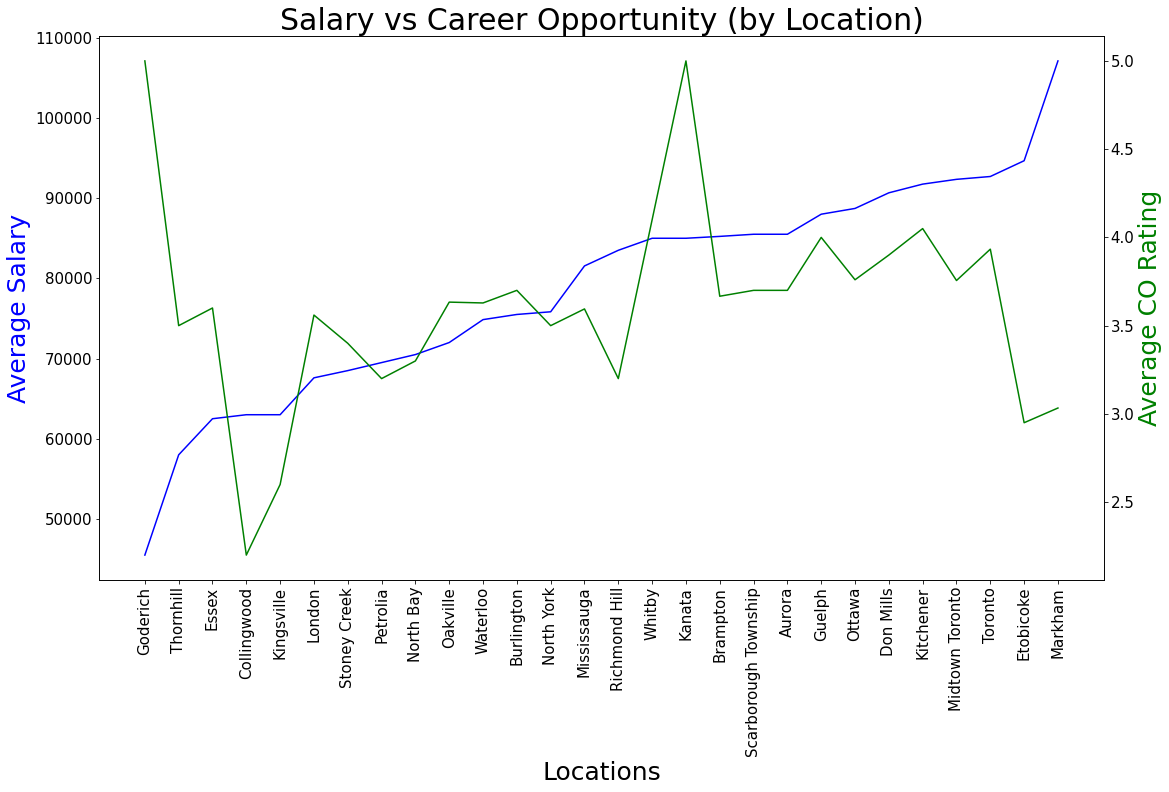

In [22]:
loc_group = salary_df.groupby('Location').mean().sort_values('Estimated Salary')
locations = loc_group.index

fig, ax1 = plt.subplots(figsize=(18,10))

ax2 = ax1.twinx()
ax1.plot(locations, loc_group['Estimated Salary'], color='b')
ax2.plot(locations, loc_group['Career Opportunitie'], color='g')

ax1.set_xlabel('Locations', size=25)
ax1.set_ylabel('Average Salary', color='b', size=25)
ax2.set_ylabel('Average CO Rating', color='g', size=25)

# Ticks
ax1.set_xticklabels(locations, rotation='vertical', size=15)
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

plt.title('Salary vs Career Opportunity (by Location)', size=30)


# What Job Functions are most in demand? What are their Salaries?

<ipython-input-20-23c1ee3e1432>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(job_func, rotation='vertical', size=15)


Text(0.5, 1.0, 'Career Opportunity vs Average Salary (by Job Function)')

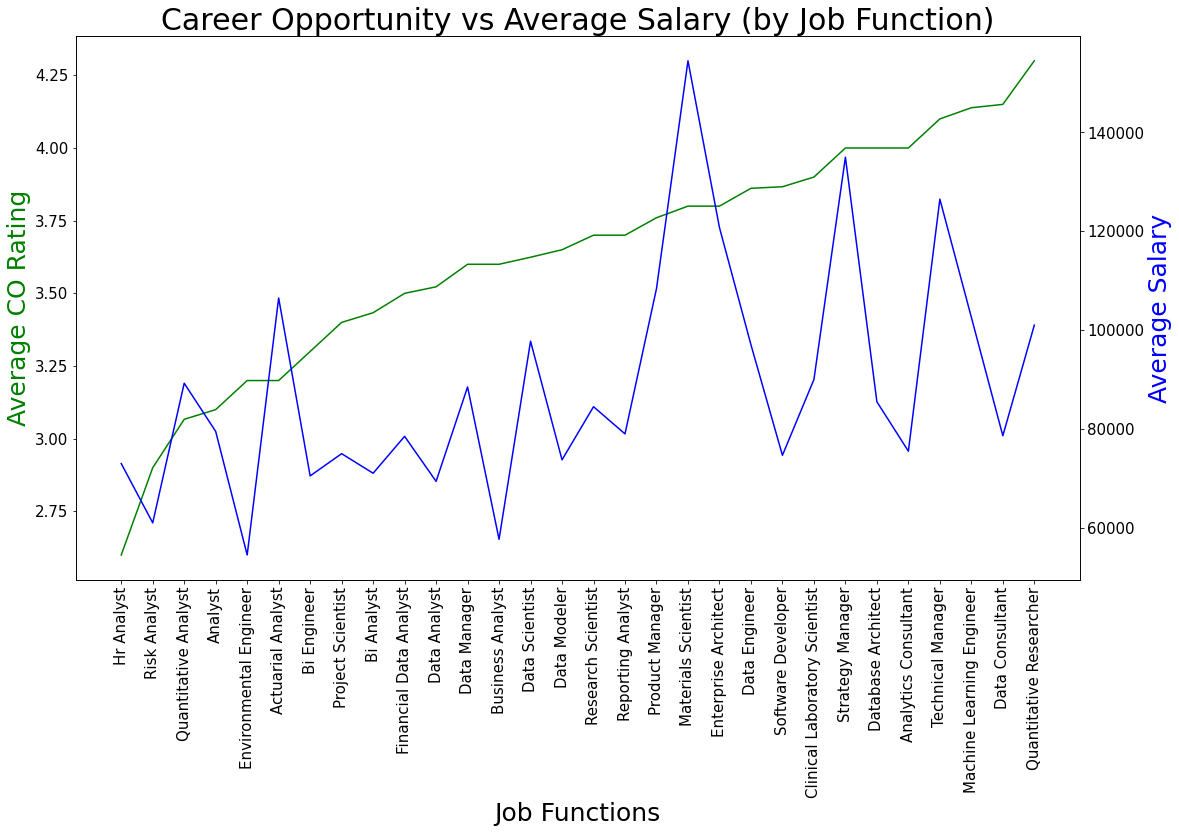

In [20]:
# Rows with NaN Salary values are already dropped since we are using salary_df
job_func_group = salary_df.groupby('Job Function').mean().sort_values('Career Opportunitie')

# Drop rows where 'Career Opportunities' is NaN
job_func_group = job_func_group[~job_func_group['Career Opportunitie'].isna()]
job_func = job_func_group.index

fig, ax1 = plt.subplots(figsize=(18,10))

ax2 = ax1.twinx()
ax1.plot(job_func, job_func_group['Career Opportunitie'], color='g')
ax2.plot(job_func, job_func_group['Estimated Salary'], color='b')

ax1.set_xlabel('Job Functions', size=25)
ax1.set_ylabel('Average CO Rating', color='g', size=25)
ax2.set_ylabel('Average Salary', color='b', size=25)

# Ticks
ax1.set_xticklabels(job_func, rotation='vertical', size=15)
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

plt.title('Career Opportunity vs Salary (by Job Function)', size=30)



# Salary vs Career Oppotunity by Company

<ipython-input-24-3c28a9162c4c>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(companies, rotation='vertical', size=15)


Text(0.5, 1.0, 'Salary vs Career Oppounity (by company)')

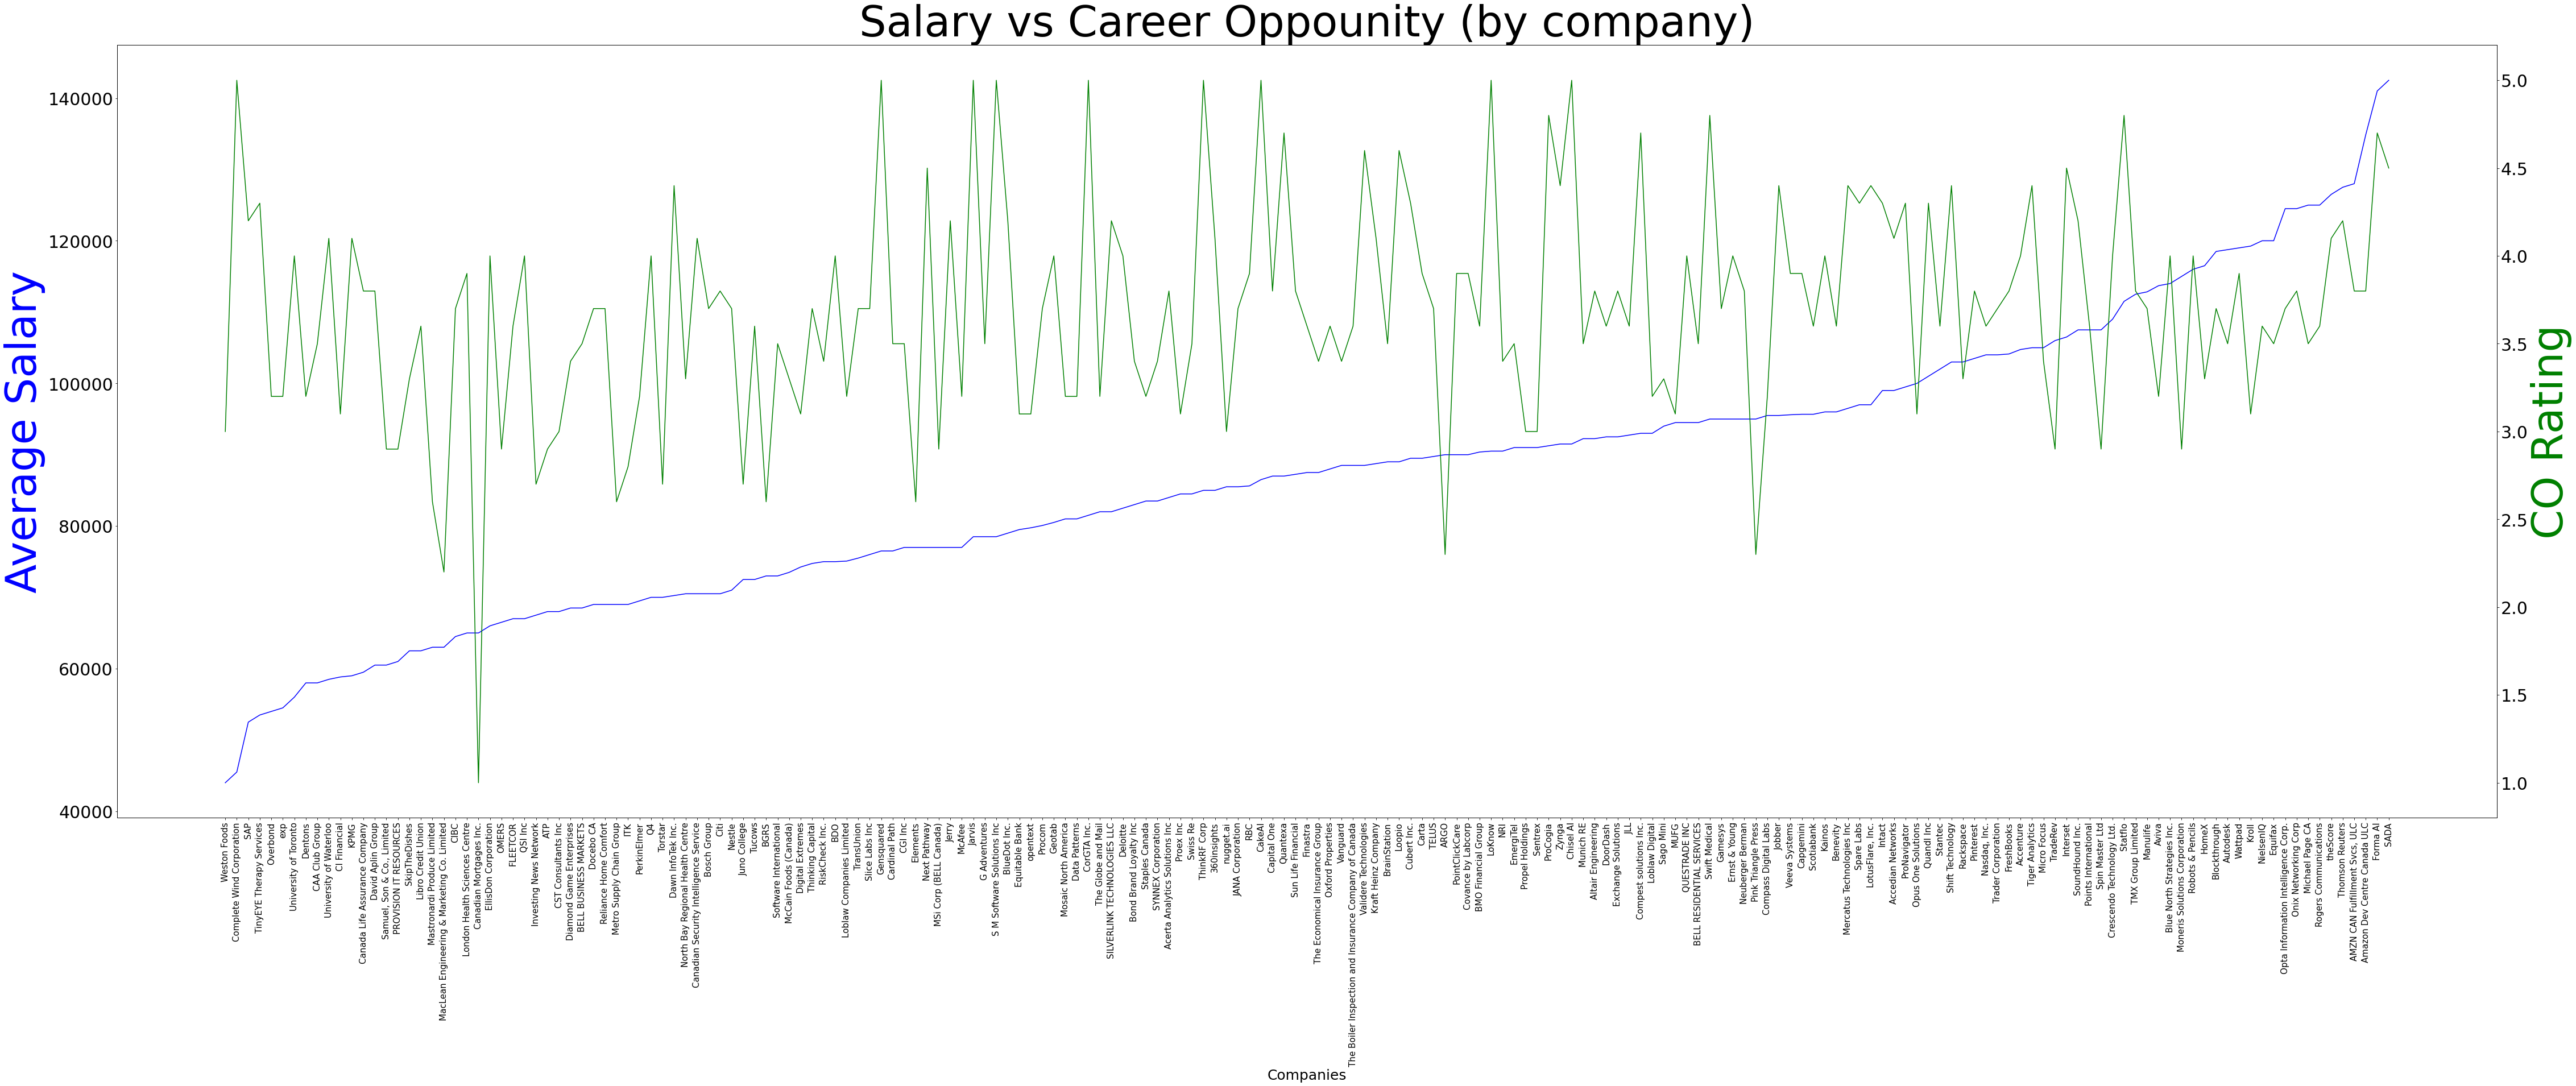

In [24]:
company_group = salary_df.groupby('Company').mean().sort_values('Estimated Salary')

# Drop rows where 'Career Opportunities' is NaN
company_group = company_group[~company_group['Career Opportunitie'].isna()]

companies = company_group.index

fig, ax1 = plt.subplots(figsize=(75,25))

ax2 = ax1.twinx()
ax1.plot(companies, company_group['Estimated Salary'], color='b')
# The CO rating of a company is the same as the average CO rating of the company because ratings are unique to a company
ax2.plot(companies, company_group['Career Opportunitie'], color='g')

ax1.set_xlabel('Companies', size=25)
ax1.set_ylabel('Average Salary', color='b', size=75)
ax2.set_ylabel('CO Rating', color='g', size=75)

# Ticks
ax1.set_xticklabels(companies, rotation='vertical', size=15)
ax1.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='y', labelsize=30)

plt.title('Salary vs Career Oppounity (by Company)', size=75)


## Let's analyze the job description of the job with the highest salary:

In [15]:
# Find the highest salary job
highest_salary_job = salary_df[salary_df['Estimated Salary'] == max(salary_df['Estimated Salary'])]
highest_salary_job

,Company,Job Title,Location,Employer Estimated Salary,Easy Apply,Special Label,Job Age,Overall Rating,Compensation & Benefit,Culture & Value,Career Opportunitie,Work/Life Balanc,Job Type,Job Function,Industry,Size,Founded,Type,Sector,Revenue,Recommend to a friend,Approve of CEO,Total Ratings,Job Description,Job Age in Hours,Estimated Salary
270,Amazon Dev Centre Canada ULC,"Applied Scientist, Alexa Speech",Midtown Toronto,CA$141k - CA$168k (Glassdoor Est.),False,NaN,5d,3.8,3.9,3.6,3.8,3.2,Full-time,Materials Scientist,Internet,10000+ Employees,1994.0,Company - Public,Information Technology,$10+ billion (USD),72%,80%,24044 Ratings,"Master's degree in Electrical Engineering, Com...",120.0,154500.0


In [16]:
with open('highest_salary_job_desc.txt', 'r') as file:
    job_desc = file.read().replace('\n', '')
job_desc

"Master's degree in Electrical Engineering, Computer Sciences, or Mathematics with specialization in speech recognition, natural language processing, image processing, or machine learning.3+ years relevant industry experienceExperience with programming languages such as C/C++, Python, Java or Perl.Amazon is looking for a passionate, talented, and inventive Scientist with a strong machine learning background to help build industry-leading Speech and Language technology. Our mission is to push the envelope in Automatic Speech Recognition (ASR), Natural Language Understanding (NLU), and Audio Signal Processing, in order to provide the best-possible experience for our customers.As a Scientist, you will work with talented peers to develop novel algorithms and modeling techniques to advance the state of the art in spoken language understanding. Your work will directly impact our customers in the form of products and services that make use of speech and language technology. You will leverage 

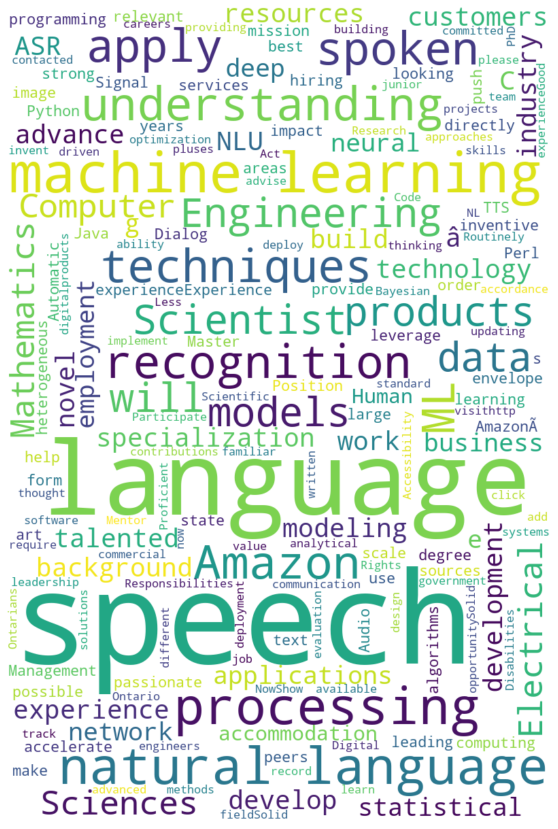

In [17]:
from wordcloud import WordCloud, STOPWORDS

stop_words = ["https", "co", "RT"] + list(STOPWORDS)

wc = WordCloud( ## declare a Wordcloud
    background_color = 'white',
    stopwords = stop_words, ## words that we want to ignore
    height = 1200,
    width = 800
)

wc.generate(job_desc)

plt.figure(figsize=(25,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# wc.to_file('wordcloud_output.png') ## outputs wordcloud as .png file